<a href="https://colab.research.google.com/github/miracle65536/XAIentists/blob/miracle65536-patch-3/Recidivism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression,make_classification
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import median_absolute_error
from sklearn import tree
import graphviz
from sklearn.metrics import accuracy_score,classification_report,class_likelihood_ratios
from sklearn.linear_model import LogisticRegression
import shap

In [23]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/compas-scores-raw.csv")

# Check first 5 rows
df.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [24]:
# prompt: check the dimension of above dataset

df.shape


(60843, 28)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60843 entries, 0 to 60842
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person_ID                60843 non-null  int64  
 1   AssessmentID             60843 non-null  int64  
 2   Case_ID                  60843 non-null  int64  
 3   Agency_Text              60843 non-null  object 
 4   LastName                 60843 non-null  object 
 5   FirstName                60843 non-null  object 
 6   MiddleName               15624 non-null  object 
 7   Sex_Code_Text            60843 non-null  object 
 8   Ethnic_Code_Text         60843 non-null  object 
 9   DateOfBirth              60843 non-null  object 
 10  ScaleSet_ID              60843 non-null  int64  
 11  ScaleSet                 60843 non-null  object 
 12  AssessmentReason         60843 non-null  object 
 13  Language                 60843 non-null  object 
 14  LegalStatus           

In [26]:
def remove_uv(df):
    return df.loc[:, df.nunique() > 1]


df_filt = remove_uv(df)
df_filt.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New


In [27]:
# df2_filtered = remove_unique_value_columns(df2)
# df2_filtered.head()

In [28]:
df_filt = df_filt.drop(['LastName', 'MiddleName', 'FirstName','ScaleSet','ScoreText','RecSupervisionLevelText'], axis=1)
df_filt.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,Scale_ID,DisplayText,RawScore,DecileScore,AssessmentType
0,50844,57167,51950,PRETRIAL,Male,Caucasian,12/05/92,22,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,7,Risk of Violence,-2.08,4,New
1,50844,57167,51950,PRETRIAL,Male,Caucasian,12/05/92,22,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,8,Risk of Recidivism,-1.06,2,New
2,50844,57167,51950,PRETRIAL,Male,Caucasian,12/05/92,22,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,18,Risk of Failure to Appear,15.00,1,New
3,50848,57174,51956,PRETRIAL,Male,Caucasian,09/16/84,22,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,7,Risk of Violence,-2.84,2,New
4,50848,57174,51956,PRETRIAL,Male,Caucasian,09/16/84,22,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,8,Risk of Recidivism,-1.50,1,New


In [29]:
plt.boxplot(df["Values"])
plt.title("Box Plot of Values")
plt.ylabel("Values")
plt.show()

KeyError: 'Values'

In [30]:
# df2 = df2.rename(columns={'first': 'FirstName', 'last': 'LastName'})

# merged_df = pd.merge(df, df2, on=['FirstName', 'LastName'], how='left')

# merged_df.head()

In [31]:
# counts = df2_filtered.count()
# print(counts)

In [32]:

# cols_with_missing = df2_filtered.columns[df2_filtered.isnull().any()]
# missing_values_count = df2_filtered.isna().sum()
# print(missing_values_count)


In [33]:
# df2_filtered = df2_filtered.dropna()

# df2_filtered.head()

In [34]:

encoder = LabelEncoder()

df_filt['Agency_Text'] = encoder.fit_transform(df['Agency_Text'])
df_filt['LegalStatus'] = encoder.fit_transform(df['LegalStatus'])
df_filt['MaritalStatus'] = encoder.fit_transform(df['MaritalStatus'])
df_filt['DisplayText'] = encoder.fit_transform(df['DisplayText'])
df_filt['CustodyStatus'] = encoder.fit_transform(df['CustodyStatus'])

In [35]:
non_numeric_columns = df_filt.select_dtypes(exclude=['number']).columns
df_filt.drop(columns=non_numeric_columns, inplace=True)
y = df_filt['DecileScore']
X = df_filt.drop('DecileScore', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)


In [36]:
reg = DecisionTreeRegressor(max_depth=3, random_state=1234)
reg.fit(X_train, y_train) # Train the data
predictions = reg.predict(X_test) # # Make the predictions
mae = median_absolute_error(y_test, predictions) #  Find the performance of the model
print('Median absolute error: %.5f' % mae)

Median absolute error: 0.75975


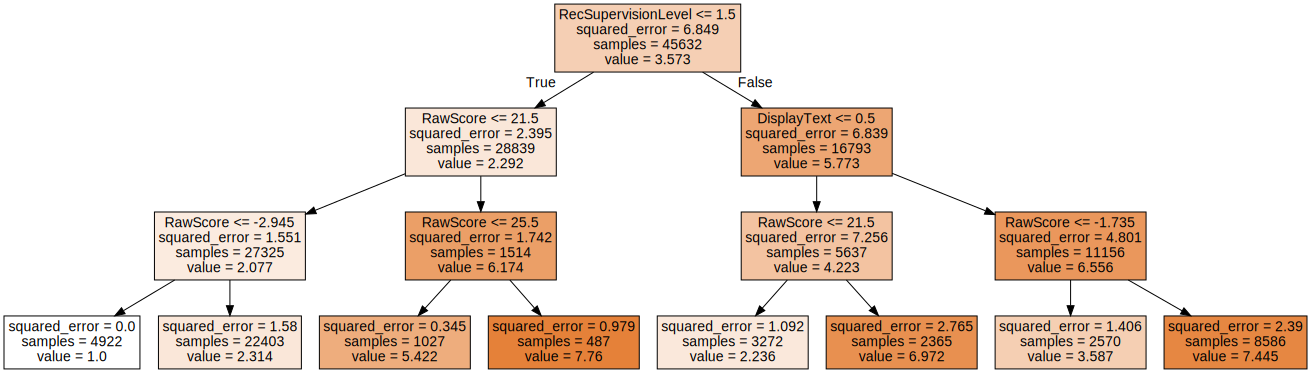

In [37]:
dot_data = tree.export_graphviz(reg, out_file=None,
                                feature_names=X_test.columns,
                                filled=True)
graphviz.Source(dot_data, format="png")

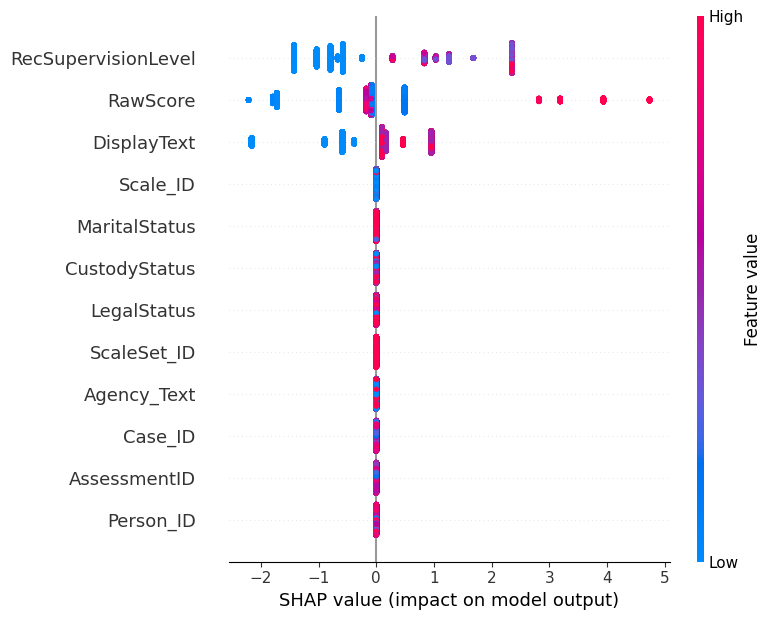

In [38]:
explainer = shap.Explainer(reg, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


In [39]:
df2 = pd.read_csv("/content/drive/MyDrive/cox-violent-parsed_filt.csv")
print(df2.columns)

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'priors_count.1', 'event'],
      dtype='object')


In [40]:
for column in df2.columns:
    if not pd.api.types.is_numeric_dtype(df2[column]):
        df2[column] = encoder.fit_transform(df2[column])

df2.head()

,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,7501,2514,2395,1,4299,69,1,5,0,...,83,0,1,1,312,0,1,1,0,0
1,2.0,7501,2514,2395,1,4299,69,1,5,0,...,83,0,1,1,312,0,1,1,0,0
2,3.0,7416,2502,4539,1,1294,31,0,2,0,...,83,0,5,2,702,0,2,1,0,0
3,4.0,6099,2003,1475,1,5229,34,0,0,0,...,54,0,3,1,604,0,1,1,0,1
4,5.0,3061,1044,4094,1,3334,24,2,0,0,...,83,0,4,1,305,0,3,1,4,0


In [41]:
df2 = df2.dropna(axis=1, how='all')

df2 = df2.dropna()

print(len(df2))

3765


In [42]:
y_2 = df2['decile_score.1']
X_2 = df2.drop('decile_score.1', axis = 1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.25, random_state=12)

In [43]:
log = LogisticRegression(max_iter=100000) # Call the model object
log.fit(X_train_2,y_train_2)   # Train the data
predictions_2 =  log.predict(X_test_2) # Make the predictions
accuracy = accuracy_score(y_test_2, predictions_2) # Lets see how accurate our models are
print(accuracy)

0.5074309978768577


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
coefficients = log.coef_[0]
feature_names = X_2.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coef_df)

                    Feature  Coefficient
0                        id    -0.000894
1                      name     0.011453
2                     first    -0.033236
3                      last    -0.000414
4                       sex     0.000032
5                       dob    -0.001323
6                       age     0.022859
7                   age_cat     0.000917
8                      race     0.002016
9             juv_fel_count    -0.000208
10             decile_score    -0.025220
11           juv_misd_count    -0.000137
12          juv_other_count    -0.000402
13             priors_count    -0.007470
14  days_b_screening_arrest     0.003014
15                c_jail_in    -0.000948
16               c_jail_out     0.000020
17       c_days_from_compas    -0.021242
18          c_charge_degree    -0.006293
19            c_charge_desc     0.013776
20                 is_recid    -0.000678
21          r_charge_degree    -0.018645
22       r_days_from_arrest    -0.020280
23           r_o